# Customer Survival Analysis

## Theory

If time to event has the probability density function $f(t)$ and cumulative distribution function $F(t)$, then the probability of surviving at least to time $t$ is: $Pr(T>t)=S(t)=1-F(t)$. 

Cumulative hazard at time t is defined as $H(t)=-ln(S(t))$ and instantaneous hazard at time $t$ is $h(t)=\frac{dH(t)}{dt}$. The instantateous hazard can also be written as $h(t)=\frac{f(t)}{S(t)}$

The likelihood function for survival analysis is described as:

$$ l(\beta) = \prod_{n=1}^{n} h(t_{i})^{d_{i}} S(t_{i}) $$
where $d_i$ is the censoring variable that equals to 1 if the event is observed for individual $i$ and 0 if the event is not observed (censored) for individual $i$, $h(t_i)$ is the hazard for individual $i$ at time $t$, $H(t_i)$ is the cumulative hazard for individual $i$ at time $t$, and $S(t_i)$ is the survival probability for individual $i$ at time $t$. Note that when $d_i=0$, the contribution of the $i$'th individual to the likelihood function is just its survival probability until time $t$: S(t). If the individual has the event, the contribution to the likelihood function is given by the density function $f(t)=h(t)S(t)$.

The log of likelihood is:

$$ logl(\beta) = \sum_{i=1}^n d_i log(h(t_i)) - H(t_i) $$
where $log$ is the natural logarithm.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#Lifelines is a survival analysis package
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

## Data Preparation

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

Here, Churn is an event which indicates whether customer exited or not. Tenure shows how long customer remained in our service. Both of these variables are very important for customer survival analysis.

In [4]:
df["Churn"] = labelencoder.fit_transform(df["Churn"])
df.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [5]:
eventvar = df['Churn']
timevar = df['tenure']

For the analysis, I will need to create dummy variables for all categorical variables.

In [6]:
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']

survivaldata = pd.get_dummies(df, columns = categorical, drop_first= True)
survivaldata.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.85,29.85,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,34,56.95,1889.5,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,2,53.85,108.15,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,45,42.30,1840.75,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,9237-HQITU,2,70.70,151.65,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


We need to drop variables such as customerID, tenure, Churn as they are not needed in survival data. Also, we need to add constant for survival analysis.

In [7]:
survivaldata.drop(['customerID', 'tenure', 'Churn'], axis = 1, inplace= True)
survivaldata = sm.add_constant(survivaldata, prepend=False)
survivaldata.head()

/Users/huitingsheng/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,const
0,29.85,29.85,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1.0
1,56.95,1889.5,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1.0
2,53.85,108.15,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1.0
3,42.30,1840.75,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1.0
4,70.70,151.65,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,1.0


## Survival Analysis

### Kaplan-Meier Curve

The Kaplan-Meier method calculates the probability of survival at time 𝑡  as:

$$ S(t) = \prod_{i=1}^{t-1} (1 - \frac{d_i}{n_i}) $$

where,
- 𝑆(𝑡) is the probability of survival until time 𝑡, 
- $𝑑_𝑖$  is the number of units that experienced the event at time 𝑡,  
- $𝑛_𝑖$  is the number of units at risk of experiencing the event at time 𝑡.  

$𝑛_𝑖$ decreases with time, as units experience the event or are censored. $\frac{d_i}{n_i}$ is the probability of experiencing the event at time 𝑖 and $(1− \frac{d_i}{n_i})$ is the probability of surviving at time 𝑖. 

Note that this method does not use any parameters, it only depends on the data on time and censoring.

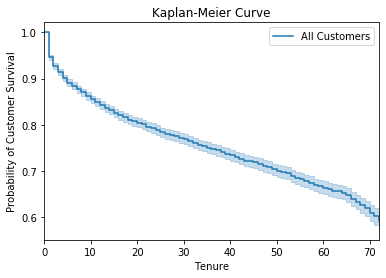

In [8]:
#Create a KaplanMeier object, imported from lifelines
kmf = KaplanMeierFitter()
#Calculate the K-M curve for all groups
kmf.fit(durations = timevar,event_observed = eventvar,label = "All Customers")
#Plot the curve and assign labels
kmf.plot()
plt.ylabel('Probability of Customer Survival')
plt.xlabel('Tenure')
plt.title('Kaplan-Meier Curve');

As we can see, there is a sudden drop in the starting which says that after one tenure only customers starts churning rapidly and after that churning rate decreases. To deal with that we can consider giving more discounts on long-term plans and make more customers to subscribe for long term plans.  

### Log-Rank Test

We can use non-parametric method log-rank test to compare survival curves between different groups. The log-rank test assumes that the hazards of the groups are proportional. Under the null hypothesis, the probability of event across the groups is the same for all time points. 

To test the null hypothesis, the log-rank test calculates the difference between the observed number of events and the number of events expected in each group proportional to the size of the groups at each time point an event is observed. The log-rank test statistic for group $j$ $(k_{j})$ follows a $\chi^2$ distribution and is calculated as:

$$k_{j} = \frac{(O_{j}-E_{j})^{2}}{var(O_{j}-E_{j})}$$

$O_{j}-E_{j}$ is calculated as:

$$O_{j}-E_{j} = \sum_{i}(o_{ij}-e_{ij})$$ 

and $var(O_{j}-E_{j})$ is:

$$var(O_{j}-E_{j}) = o_{i}\frac{n_{ij}}{n_{i}}\Big(1-\frac{n_{ij}}{n_{i}}\Big)\frac{(n_{i}-o_{i})}{(n_{i}-1)}$$

$o_{ij}$ is the observed number of events in group $j$ at time $i$ and $e_{ij}$ is the expected number of events in group $j$ at time $i$, which is calculated as $e_{ij} = \frac{n_{ij}}{n_i}{o_{i}}$. Note that $\frac{n_{ij}}{n_i}$ is the proportion of units in group $j$ at risk of event at time $i$ ($n_{ij}$) to the number of units in all groups at risk of event at time $i$ ($n_{i}$) and ${o_{i}}$ is the observed number of events in all groups at time $i$. 

When comparing multiple groups, we first calculate the pairwise log-rank test scores between each of the $k-1$ groups, and write them as a vector of log-rank statistics, $\bf{Z}$ which has $k - 1$ elements. We can leave any of one of the statistics out, because the $k$ covariances are linearly dependent on each other (the sum of log-rank statistics is 0, $\sum k_{j}=0$.

The test statistic for the hypothesis that there is no difference in survival times of $k$ groups is calculated as: 

$$logrankstatistic = \bf{Z} {\sum}^{-1} \bf{Z}'$$ 

which has a $\chi^2$ distribution, where ${\sum}^{-1}$ is the inverse of the $k-1$ by $k-1$ variance-covariance matrix of $\bf{Z}$, which has variance of $k_{j}$ on its diagonal elements and $covar(k_{jg})$ on its off-diagonal elements.

The variance of observed number of events in group $j$ is calculated as $var(O_{j}-E_{j})$ as demonstrated above. The covariance between the observed number of events in group $j$ and $g$ is calculated as:

$$covar(k_{jg})=o_{i}\frac{(n_{ij}n_{ig})}{(n_{i}n_{i})}\frac{(n_{i}-o_{i})}{(n_{i}-1)}$$

Note that rejecting the null hypothesis means that the survival times of groups do not come from the same distribution, it does not specify which group's survival time is different. The following plots and test statistics compare the groups in the dataset in terms of the different explanatory variables. Astatistically significant log-rank test statistic indicates that we can reject the null hypothesis that time to survival in all groups come from the same distribution.

### Gender

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.53 0.47      1.09

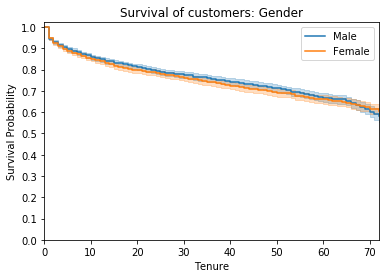

In [9]:
male = (survivaldata['gender_Male'] == 1)
female = (survivaldata['gender_Male'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(durations = timevar[male],event_observed = eventvar[male],label = "Male")
plot1 = kmf.plot(ax = ax)

kmf.fit(durations = timevar[female],event_observed = eventvar[female],label = "Female")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Gender')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[male], timevar[female], event_observed_A=eventvar[male], event_observed_B=eventvar[female])
groups.print_summary()

### Senior Citizen

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         109.49 <0.005     82.71

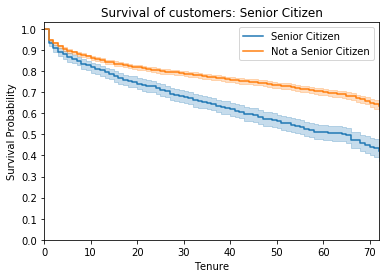

In [10]:
SeniorCitizen = (survivaldata['SeniorCitizen_1'] == 1)
no_SeniorCitizen = (survivaldata['SeniorCitizen_1'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(durations = timevar[SeniorCitizen],event_observed = eventvar[SeniorCitizen],label = "Senior Citizen")
plot1 = kmf.plot(ax = ax)

kmf.fit(durations = timevar[no_SeniorCitizen],event_observed = eventvar[no_SeniorCitizen],label = "Not a Senior Citizen")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Senior Citizen')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[SeniorCitizen], timevar[no_SeniorCitizen], event_observed_A=eventvar[SeniorCitizen], event_observed_B=eventvar[no_SeniorCitizen])
groups.print_summary()

In [11]:
#regression_df.head()
# SeniorCitizen = df[df["SeniorCitizen"] == 1]
# non_senior = df[df["SeniorCitizen"] == 0]
# plt.figure()
# ax = plt.subplot(1,1,1)

# kmf.fit(durations = SeniorCitizen["tenure"], event_observed = SeniorCitizen["Churn"], label = "Senior")
# plot1 = kmf.plot(ax = ax)
# kmf.fit(durations = non_senior["tenure"], event_observed = non_senior["Churn"], label = "non-Senior")
# plot2 = kmf.plot(ax = plot1)

# plt.title('Survival of customers: Senior Citizen')
# plt.xlabel('Tenure')
# plt.ylabel('Survival Probability')
# plt.yticks(np.linspace(0,1,11))
# groups = logrank_test(SeniorCitizen["tenure"], non_senior["tenure"], event_observed_A=SeniorCitizen["Churn"], event_observed_B=non_senior["Churn"])
# groups.print_summary()

### Partner

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         423.54 <0.005    310.21

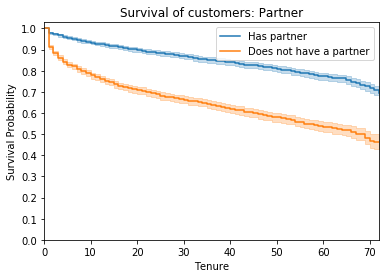

In [12]:
partner = (survivaldata['Partner_Yes'] == 1)
no_partner = (survivaldata['Partner_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(durations = timevar[partner],event_observed = eventvar[partner],label = "Has partner")
plot1 = kmf.plot(ax = ax)

kmf.fit(durations = timevar[no_partner],event_observed = eventvar[no_partner],label = "Does not have a partner")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Partner')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[partner], timevar[no_partner], event_observed_A=eventvar[partner], event_observed_B=eventvar[no_partner])
groups.print_summary()

### Dependents

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         232.70 <0.005    172.12

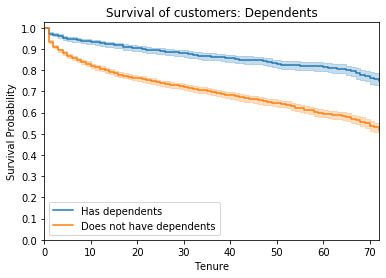

In [13]:
Dependents = (survivaldata['Dependents_Yes'] == 1)
no_Dependents = (survivaldata['Dependents_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(durations = timevar[Dependents],event_observed = eventvar[Dependents],label = "Has dependents")
plot1 = kmf.plot(ax = ax)

kmf.fit(durations = timevar[no_Dependents],event_observed = eventvar[no_Dependents],label = "Does not have dependents")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Dependents')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[Dependents], timevar[no_Dependents], event_observed_A=eventvar[Dependents], event_observed_B=eventvar[no_Dependents])
groups.print_summary()

### PhoneService

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.43 0.51      0.97

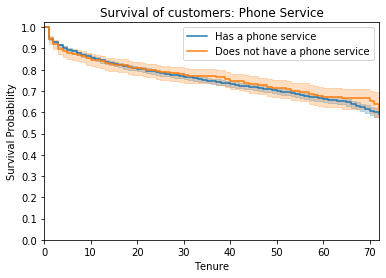

In [14]:
PhoneService = (survivaldata['PhoneService_Yes'] == 1)
no_PhoneService = (survivaldata['PhoneService_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(durations = timevar[PhoneService],event_observed = eventvar[PhoneService],label = "Has a phone service")
plot1 = kmf.plot(ax = ax)

kmf.fit(durations = timevar[no_PhoneService],event_observed = eventvar[no_PhoneService],label = "Does not have a phone service")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Phone Service')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[PhoneService], timevar[no_PhoneService], event_observed_A=eventvar[PhoneService], event_observed_B=eventvar[no_PhoneService])
groups.print_summary()

### MultipleLines

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          30.97 <0.005     22.34

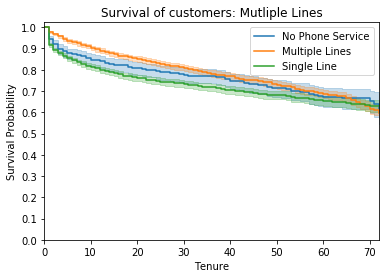

In [15]:
no_phone = (survivaldata['MultipleLines_No phone service'] == 1)
multiLines = (survivaldata['MultipleLines_Yes'] == 1)
no_multiLines = ((survivaldata['MultipleLines_Yes'] == 0) & (survivaldata['MultipleLines_No phone service'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(durations = timevar[no_phone],event_observed = eventvar[no_phone],label = "No Phone Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(durations = timevar[multiLines],event_observed = eventvar[multiLines],label = "Multiple Lines")
plot2 = kmf.plot(ax = plot1)

kmf.fit(durations = timevar[no_multiLines],event_observed = eventvar[no_multiLines],label = "Single Line")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Mutliple Lines')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['MultipleLines'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Internet Service

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         520.12 <0.005    375.19

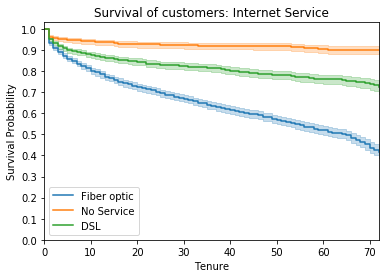

In [16]:
Fiber_optic = (survivaldata['InternetService_Fiber optic'] == 1)
No_Service = (survivaldata['InternetService_No'] == 1)
DSL = ((survivaldata['InternetService_Fiber optic'] == 0) & (survivaldata['InternetService_No'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(durations = timevar[Fiber_optic],event_observed = eventvar[Fiber_optic],label = "Fiber optic")
plot1 = kmf.plot(ax = ax)

kmf.fit(durations = timevar[No_Service],event_observed = eventvar[No_Service],label = "No Service")
plot2 = kmf.plot(ax = plot1)

kmf.fit(durations = timevar[DSL],event_observed = eventvar[DSL],label = "DSL")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Internet Service')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['InternetService'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Online Security

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        1013.86 <0.005    731.35

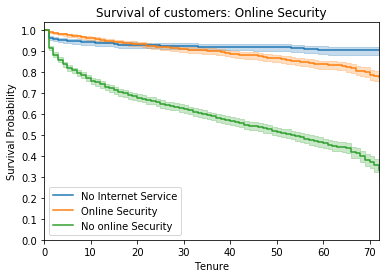

In [17]:
no_internetService = (survivaldata['OnlineSecurity_No internet service'] == 1)
onlineSecurity = (survivaldata['OnlineSecurity_Yes'] == 1)
no_onlineSecurity = ((survivaldata['OnlineSecurity_No internet service'] == 0) & (survivaldata['OnlineSecurity_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(durations = timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(durations =timevar[onlineSecurity],event_observed = eventvar[onlineSecurity],label = "Online Security")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_onlineSecurity],event_observed = eventvar[no_onlineSecurity],label = "No online Security")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Online Security')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['OnlineSecurity'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Online Backup

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         821.34 <0.005    592.47

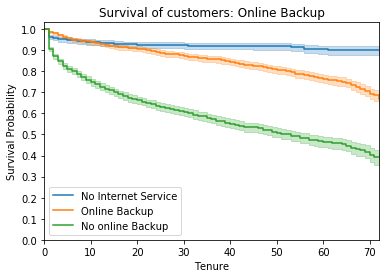

In [18]:
no_internetService = (survivaldata['OnlineBackup_No internet service'] == 1)
onlineBackup = (survivaldata['OnlineBackup_Yes'] == 1)
no_onlineBackup = ((survivaldata['OnlineBackup_No internet service'] == 0) & (survivaldata['OnlineBackup_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[onlineBackup],event_observed = eventvar[onlineBackup],label = "Online Backup")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_onlineBackup],event_observed = eventvar[no_onlineBackup],label = "No online Backup")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Online Backup')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['OnlineBackup'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Device Protection

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         763.51 <0.005    550.75

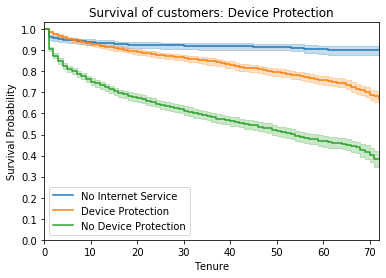

In [19]:
no_internetService = (survivaldata['DeviceProtection_No internet service'] == 1)
DeviceProtection = (survivaldata['DeviceProtection_Yes'] == 1)
no_DeviceProtection = ((survivaldata['DeviceProtection_No internet service'] == 0) & (survivaldata['DeviceProtection_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[DeviceProtection],event_observed = eventvar[DeviceProtection],label = "Device Protection")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_DeviceProtection],event_observed = eventvar[no_DeviceProtection],label = "No Device Protection")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Device Protection')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['DeviceProtection'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Tech Support

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         989.56 <0.005    713.82

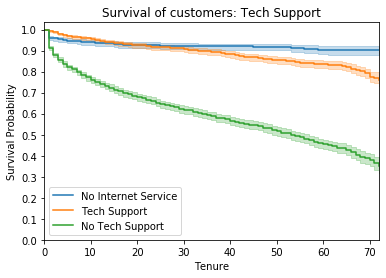

In [20]:
no_internetService = (survivaldata['TechSupport_No internet service'] == 1)
TechSupport = (survivaldata['TechSupport_Yes'] == 1)
no_TechSupport = ((survivaldata['TechSupport_No internet service'] == 0) & (survivaldata['TechSupport_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[TechSupport],event_observed = eventvar[TechSupport],label = "Tech Support")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_TechSupport],event_observed = eventvar[no_TechSupport],label = "No Tech Support")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Tech Support')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['TechSupport'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Streaming TV

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         368.31 <0.005    265.68

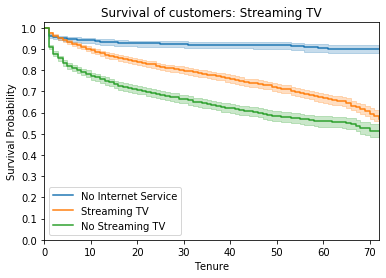

In [21]:
no_internetService = (survivaldata['StreamingTV_No internet service'] == 1)
StreamingTV = (survivaldata['StreamingTV_Yes'] == 1)
no_StreamingTV = ((survivaldata['StreamingTV_No internet service'] == 0) & (survivaldata['StreamingTV_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[StreamingTV],event_observed = eventvar[StreamingTV],label = "Streaming TV")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_StreamingTV],event_observed = eventvar[no_StreamingTV],label = "No Streaming TV")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Streaming TV')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['StreamingTV'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Streaming Movies

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         378.43 <0.005    272.98

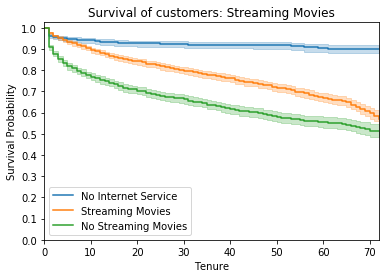

In [22]:
no_internetService = (survivaldata['StreamingMovies_No internet service'] == 1)
StreamingMovies = (survivaldata['StreamingMovies_Yes'] == 1)
no_StreamingMovies = ((survivaldata['StreamingMovies_No internet service'] == 0) & (survivaldata['StreamingMovies_Yes'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[no_internetService],event_observed = eventvar[no_internetService],label = "No Internet Service")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[StreamingMovies],event_observed = eventvar[StreamingMovies],label = "Streaming Movies")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[no_StreamingMovies],event_observed = eventvar[no_StreamingMovies],label = "No Streaming Movies")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Streaming Movies')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['StreamingMovies'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Contract

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        2352.87 <0.005       inf

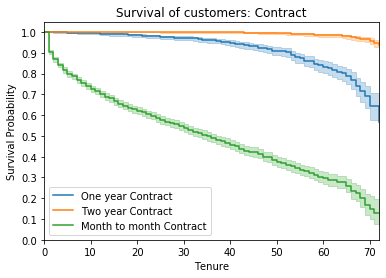

In [23]:
Contract_One_year = (survivaldata['Contract_One year'] == 1)
Contract_Two_year = (survivaldata['Contract_Two year'] == 1)
Contract_month_to_month = ((survivaldata['Contract_One year'] == 0) & (survivaldata['Contract_Two year'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[Contract_One_year],event_observed = eventvar[Contract_One_year],label = "One year Contract")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[Contract_Two_year],event_observed = eventvar[Contract_Two_year],label = "Two year Contract")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[Contract_month_to_month],event_observed = eventvar[Contract_month_to_month],label = "Month to month Contract")
plot3 = kmf.plot(ax = plot2)
                 
plt.title('Survival of customers: Contract')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['Contract'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Payment Method

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
             alpha = 0.95
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         865.24 <0.005    619.58

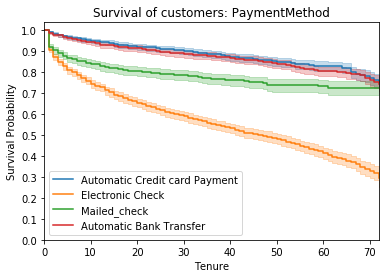

In [24]:
automatic_Credit_Card = (survivaldata['PaymentMethod_Credit card (automatic)'] == 1)
electronic_check = (survivaldata['PaymentMethod_Electronic check'] == 1)
mailed_check = (survivaldata['PaymentMethod_Mailed check'] == 1)
automatic_Bank_Transfer = ((survivaldata['PaymentMethod_Credit card (automatic)'] == 0) & (survivaldata['PaymentMethod_Electronic check'] == 0) & (survivaldata['PaymentMethod_Mailed check'] == 0))

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[automatic_Credit_Card],event_observed = eventvar[automatic_Credit_Card],label = "Automatic Credit card Payment")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[electronic_check],event_observed = eventvar[electronic_check],label = "Electronic Check")
plot2 = kmf.plot(ax = plot1)

kmf.fit(timevar[mailed_check],event_observed = eventvar[mailed_check],label = "Mailed_check")
plot3 = kmf.plot(ax = plot2)

kmf.fit(timevar[automatic_Bank_Transfer],event_observed = eventvar[automatic_Bank_Transfer],label = "Automatic Bank Transfer")
plot4 = kmf.plot(ax = plot3)
                 
plt.title('Survival of customers: PaymentMethod')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
twoplusgroups_logrank = multivariate_logrank_test(df['tenure'], df['PaymentMethod'], df['Churn'], alpha = 0.95)
twoplusgroups_logrank.print_summary()

### Paperless Billing

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         189.51 <0.005    140.82

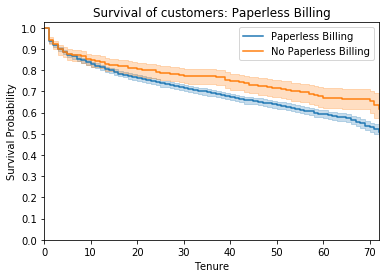

In [25]:
PaperlessBilling = (survivaldata['PaperlessBilling_Yes'] == 1)
no_PaperlessBilling = (survivaldata['PaperlessBilling_Yes'] == 0)

plt.figure()
ax = plt.subplot(1,1,1)

kmf.fit(timevar[PaperlessBilling],event_observed = eventvar[PaperlessBilling],label = "Paperless Billing")
plot1 = kmf.plot(ax = ax)

kmf.fit(timevar[no_PhoneService],event_observed = eventvar[no_PhoneService],label = "No Paperless Billing")
plot2 = kmf.plot(ax = plot1)
                 
plt.title('Survival of customers: Paperless Billing')
plt.xlabel('Tenure')
plt.ylabel('Survival Probability')
plt.yticks(np.linspace(0,1,11))
groups = logrank_test(timevar[PaperlessBilling], timevar[no_PaperlessBilling], event_observed_A=eventvar[PaperlessBilling], event_observed_B=eventvar[no_PaperlessBilling])
groups.print_summary()

## Survival Regression

In [26]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
    
    return df

In [27]:
regression_df = datapreparation("Telco-Customer-Churn.csv")
regression_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0


#### Survival Regression Ananlysis using Cox Proportional Hazard model

In [28]:
cph = CoxPHFitter()
cph.fit(regression_df, duration_col='tenure', event_col='Churn')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12659.69
         time fit was run = 2022-01-31 05:30:30 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
gender                                  0.04       1.04       0.05            -0.05             0.13                 0.95                 1.14
SeniorCitizen                           0.03       1.04       0.06            -0.08             0.15                 0.93                 1.16
Partner                                -0.18       0.84       0.06            -0.29            -0.07                 0.75                 0.93
Dependents                             -0.09       0.91       0.07            -0.23             0.05                 0.80                 1.05
PhoneService                            0.83       2.29       0.47            -0.10             1.76                 0.90                 5.80
MultipleLines                           0.09       1.09       0.13            -0.16             0.33                 0.85                 1.40
OnlineSecurity                         -0.21       0.81       0.13            -0.47             0.05                 0.62                 1.05
OnlineBackup                           -0.06       0.95       0.13            -0.31             0.19                 0.74                 1.21
DeviceProtection                        0.09       1.09       0.13            -0.16             0.34                 0.85                 1.40
TechSupport                            -0.08       0.92       0.13            -0.34             0.17                 0.71                 1.19
StreamingTV                             0.28       1.32       0.24            -0.18             0.74                 0.83                 2.10
StreamingMovies                         0.29       1.33       0.24            -0.18             0.75                 0.84                 2.11
PaperlessBilling                        0.15       1.16       0.06             0.04             0.26                 1.04                 1.30
MonthlyCharges                          0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
InternetService_Fiber optic             1.02       2.77       0.58            -0.12             2.15                 0.89                 8.59
InternetService_No                     -2.34       0.10       0.60            -3.51            -1.17                 0.03                 0.31
Contract_One year                      -1.27       0.28       0.10            -1.46            -1.07                 0.23                 0.34
Contract_Two year                      -3.70       0.02       0.20            -4.10            -3.31                 0.02                 0.04
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.19             0.17                 0.83                 1.18
PaymentMethod_Electronic check          0.39       1.47       0.07             0.24             0.53                 1.28                 1.70
PaymentMethod_Mailed check              0.51       1.67       0.09             0.34             0.68                 1.40                 1.98

                                           z      p   -log2(p)
covariate                                                     
gender                                  0.85   0.40       1.33
SeniorCitizen

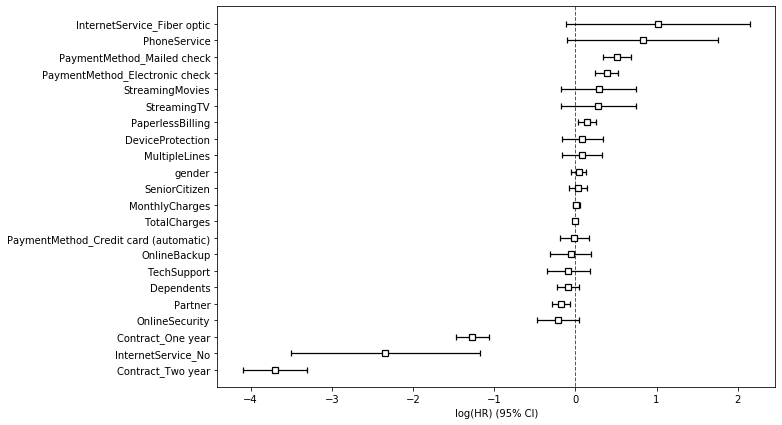

In [29]:
fig, ax = plt.subplots(figsize = (10,7))
cph.plot(ax = ax);

In [30]:
test_id = regression_df.sample(1)
test_id

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2200,1,0,0,0,19,1,0,0,1,0,...,58.2,1045.25,0,0,0,1,0,0,1,0


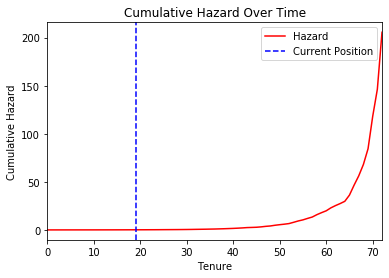

In [31]:
fig, ax = plt.subplots()
cph.predict_cumulative_hazard(test_id).plot(ax = ax, color = 'red')
plt.axvline(x=test_id.tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Hazard','Current Position'])
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Cumulative Hazard', size = 10)
ax.set_title('Cumulative Hazard Over Time');

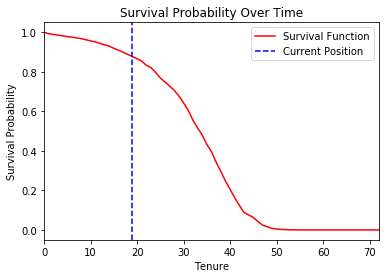

In [32]:
fig, ax = plt.subplots()
cph.predict_survival_function(test_id).plot(ax = ax, color = 'red')
plt.axvline(x=test_id.tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Survival Function','Current Position'])
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Survival Probability', size = 10)
ax.set_title('Survival Probability Over Time');

Saving the model

In [33]:
import pickle
pickle.dump(cph, open('survivemodel.pkl','wb'))

## Customer Lifetime Value

To calculate customer lifetime value, I would multiply the Monthly charges the customer is paying to Telcom and the expected life time of the customer. 

I utilize the survival function of a customer to calculate its expected life time. I would like to be little bit conservative and consider the customer is churned when the survival probability of him is 80%. 

In [38]:
def LTV(info):
    life = cph.predict_survival_function(info).reset_index()
    life.columns = ['Tenure', 'Probability']
    max_life = life.Tenure[life.Probability > 0.8].max()
    LTV = round(max_life * info['MonthlyCharges'].values[0],2)
    return LTV

In [39]:
print('LTV of a testid is:', LTV(test_id), 'dollars.')

LTV of a testid is: 1338.6 dollars.
